# Some exposure to machine learning

This notebook will take you through a very quick trip of machine learning.

We will start out by creating some simple data, then we will fit these data in various ways. We will start very simple with a 1D example.

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astroML.datasets import generate_mu_z

## The expanding universe

One of the more remarkable discoveries of the last 30 years in astronomy is the discovery that the universe is not just expanding but that the expansion is accelerating. This was awarded the Nobel prize in physics in 2011. We are not redoing that, but one key ingredient used in that kind of study is the relationship between redshift, $z$, which measures the recession velocity of an object relative to us, and the distance to the object - in the case of the Nobel prize study this was obtained from a particular type of exploding star, a Supernova type Ia, but here we will just generate this distance with the `generate_mu_z` function (this returns what is known as the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus)).

In [52]:

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=5)

z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(cosmo.distmod(z))


Text(0, 0.5, 'Distance modulus')

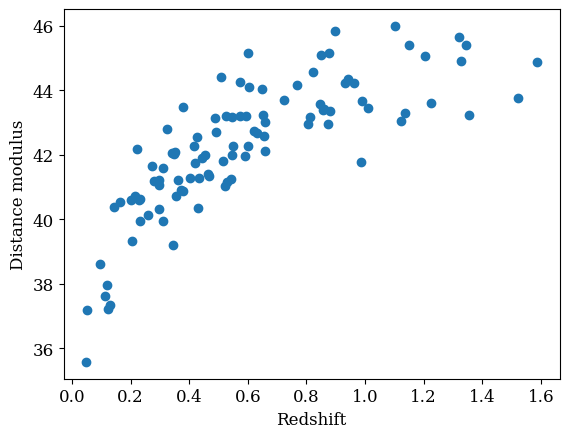

In [53]:
plt.scatter(z_sample, mu_sample)
plt.xlabel('Redshift')
plt.ylabel('Distance modulus')

## Select a training and test set

It is very important that we do not fit data and use that data to check how well our fit works. For that reason we typically define a training set (used for fitting) and a test set (used to evaluation how well the fit works). I will use `train_test_split` in `sklearn` for that here:

In [54]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(mu_sample), dtype=int)
i_train, i_test = train_test_split(indices)

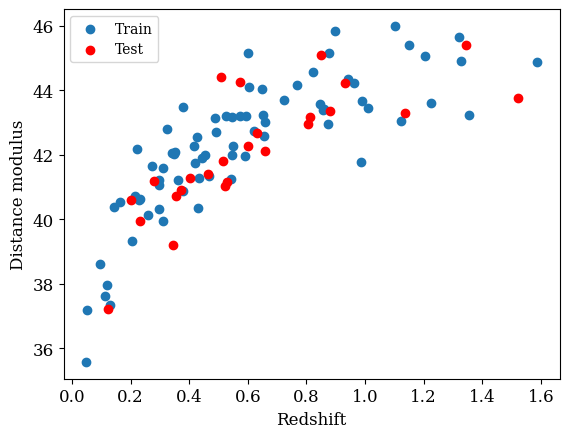

In [55]:
plt.scatter(z_sample[i_train], mu_sample[i_train], label='Train')
plt.scatter(z_sample[i_test], mu_sample[i_test], color='red', label='Test')
plt.xlabel('Redshift')
plt.ylabel('Distance modulus')
plt.legend()

## Fit a series of polynomials

We now want to model these data. In particular we will assume that the data are well represented by a polynomial:
$$
f(x) = \sum_{i=0}^M a_i x^i
$$
but where we do not know the value of $M$, so we need to fit a series of polynomials and see which does best.

The simplest way to assess the quality of the fit is to calculate the mean square error
$$
\mathrm{MSE} = \frac{1}{N} \sum_i (y_i - \mathrm{model})^2
$$
but this tends to prefer more complex models. We therefore often calculate an _information criterion_. The two most popular are the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC) and the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC), which are defined as 
$$
\mathrm{BIC} = 2 \mathrm{MSE} + M \log_{10} N,
$$
where $M$ is the number of parameters and $N$ the number of datapoints.  And
$$
\mathrm{AIC} = 2 M + 2 \mathrm{MSE}
$$.

We then look for the minimum BIC and AIC

In [56]:
n_orders = 15
orders = np.arange(n_orders)

MSE_train = np.zeros(n_orders)
MSE_test = np.zeros(n_orders)
BIC = np.zeros(n_orders)
AIC = np.zeros(n_orders)

best_fit = []

for i, order in enumerate(orders):
    # Fit the training sample using polyfit
    p = np.polyfit(z_sample[i_train], mu_sample[i_train], order)
    best_fit.append(p)
    
    # Calculate the best fit on the training sample
    mu_fit_train = np.polyval(p, z_sample[i_train])
    MSE_train[i] = np.sum((mu_sample[i_train]-mu_fit_train)**2)/len(i_train)
    
    # Calculate the best fit on the test sample
    mu_fit_test = np.polyval(p, z_sample[i_test])
    MSE_test[i] = np.sum((mu_sample[i_test]-mu_fit_test)**2)/len(i_test)

    # And finally calculate the best information criterion
    BIC[i] = 2*MSE_test[i] + order*np.log10(len(i_test))
    AIC[i] = 2*order + 2*MSE_test[i]
    

In [57]:
def get_extrema_and_index(x, y):
    """Find the minimum and maximum of a curve y_i=f(x_i) and return the indices as well"""

    i_min = np.argmin(y)
    i_max = np.argmax(y)

    return i_min, i_max, x[i_min], x[i_max]


In [58]:
i_min_mse_train, i_max_mse_train, min_mse_train, max_mse_train = get_extrema_and_index(orders, MSE_train)
print("The minimum MSE for the training sample happens for polynomial order {0}".format(min_mse_train))
print("The maximum MSE for the training sample happens for polynomial order {0}".format(max_mse_train))

The minimum MSE for the training sample happens for polynomial order 14
The maximum MSE for the training sample happens for polynomial order 0


We should not evaluate the quality of the fit on the training data so: 

**Task**: what is the best polynomial order for these data? Plot the best and worst models (considering MSE) on the test and training data on top of the data.

In [59]:
result = {}

for what in ['MSE-train', 'MSE-test', 'AIC', 'BIC']:
    if what == 'MSE-train':
        y = MSE_train
    elif what == 'MSE-test':
        y = MSE_test
    elif what == 'AIC':
        y = AIC
    elif what == 'BIC':
        y = BIC
    else:
        print("Error!")
        break

    i_min, i_max, min_val, max_val = get_extrema_and_index(orders, y)
    result[what] = {'min': min_val, 'max': max_val, 'i_min': i_min, 'i_max': i_max}

    print("{0}:  Min={1}   Max={2}".format(what, min_val, max_val))

MSE-train:  Min=14   Max=0
MSE-test:  Min=2   Max=14
AIC:  Min=1   Max=14
BIC:  Min=1   Max=14


Text(0, 0.5, 'AIC or BIC')

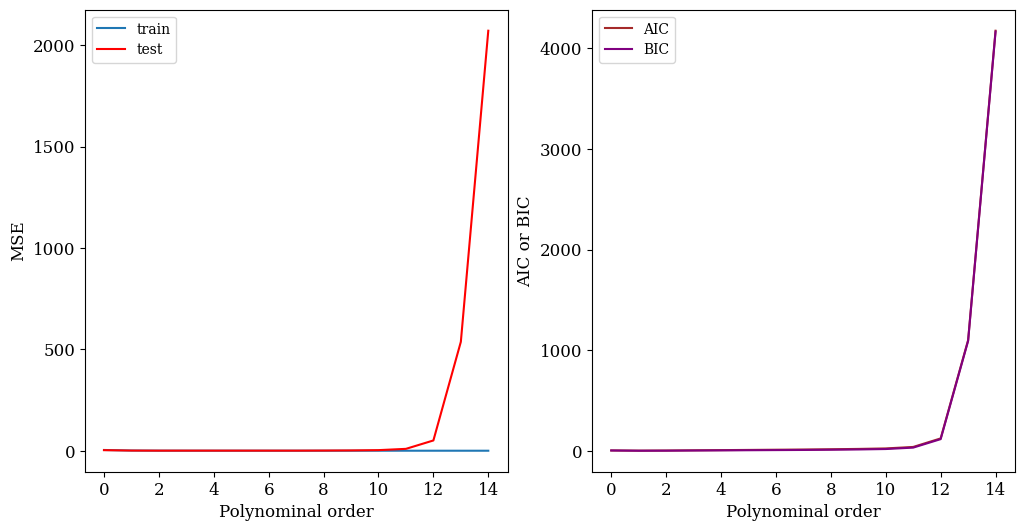

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(orders, MSE_train, label='train')
ax[0].plot(orders, MSE_test, color='red', label='test')
ax[0].legend()
ax[0].set_xlabel('Polynominal order')
ax[0].set_ylabel('MSE')
ax[1].plot(orders, AIC, color='brown', label='AIC')
ax[1].plot(orders, BIC, color='purple', label='BIC')
ax[1].legend()
ax[1].set_xlabel('Polynominal order')
ax[1].set_ylabel('AIC or BIC')

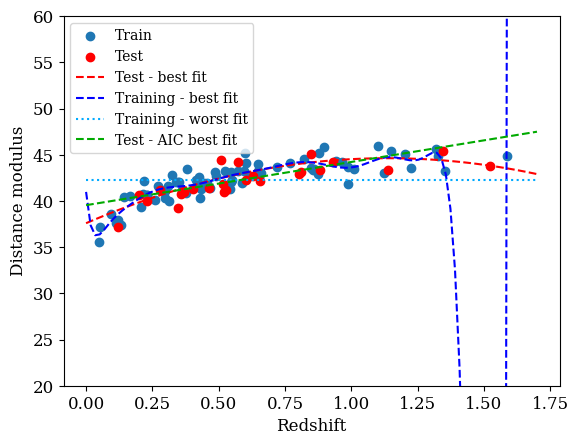

In [64]:
plt.scatter(z_sample[i_train], mu_sample[i_train], label='Train')
plt.scatter(z_sample[i_test], mu_sample[i_test], color='red', label='Test')


x_plot = np.linspace(0, 1.7, 100)
p = best_fit[result['MSE-test']['i_min']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='red', linestyle='dashed', label='Test - best fit')

p = best_fit[result['MSE-train']['i_min']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='blue', linestyle='dashed', label='Training - best fit')

p = best_fit[result['MSE-train']['i_max']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='#00aaff', linestyle='dotted', label='Training - worst fit')


p = best_fit[result['AIC']['i_min']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='#00aa00', linestyle='dashed', label='Test - AIC best fit')



plt.ylim(20, 60)
plt.xlabel('Redshift')
plt.ylabel('Distance modulus')
plt.legend()

Here it is probably best to zoom in and exclude the worst fits:

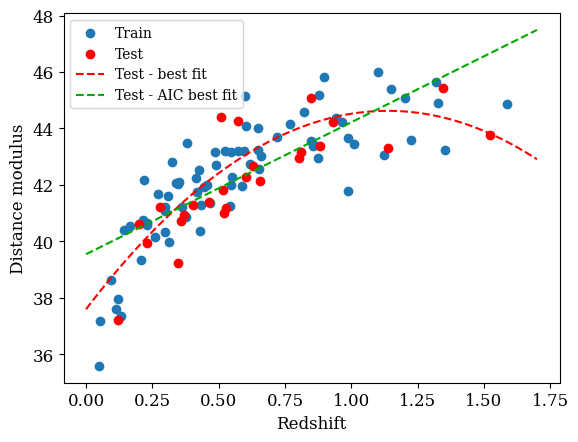

In [65]:
plt.scatter(z_sample[i_train], mu_sample[i_train], label='Train')
plt.scatter(z_sample[i_test], mu_sample[i_test], color='red', label='Test')


x_plot = np.linspace(0, 1.7, 100)
p = best_fit[result['MSE-test']['i_min']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='red', linestyle='dashed', label='Test - best fit')

p = best_fit[result['AIC']['i_min']]
y_fit = np.polyval(p, x_plot)
plt.plot(x_plot, y_fit, color='#00aa00', linestyle='dashed', label='Test - AIC best fit')

plt.xlabel('Redshift')
plt.ylabel('Distance modulus')
plt.legend()

## Discussion

So, what is happening here? Well, there are multiple stories:

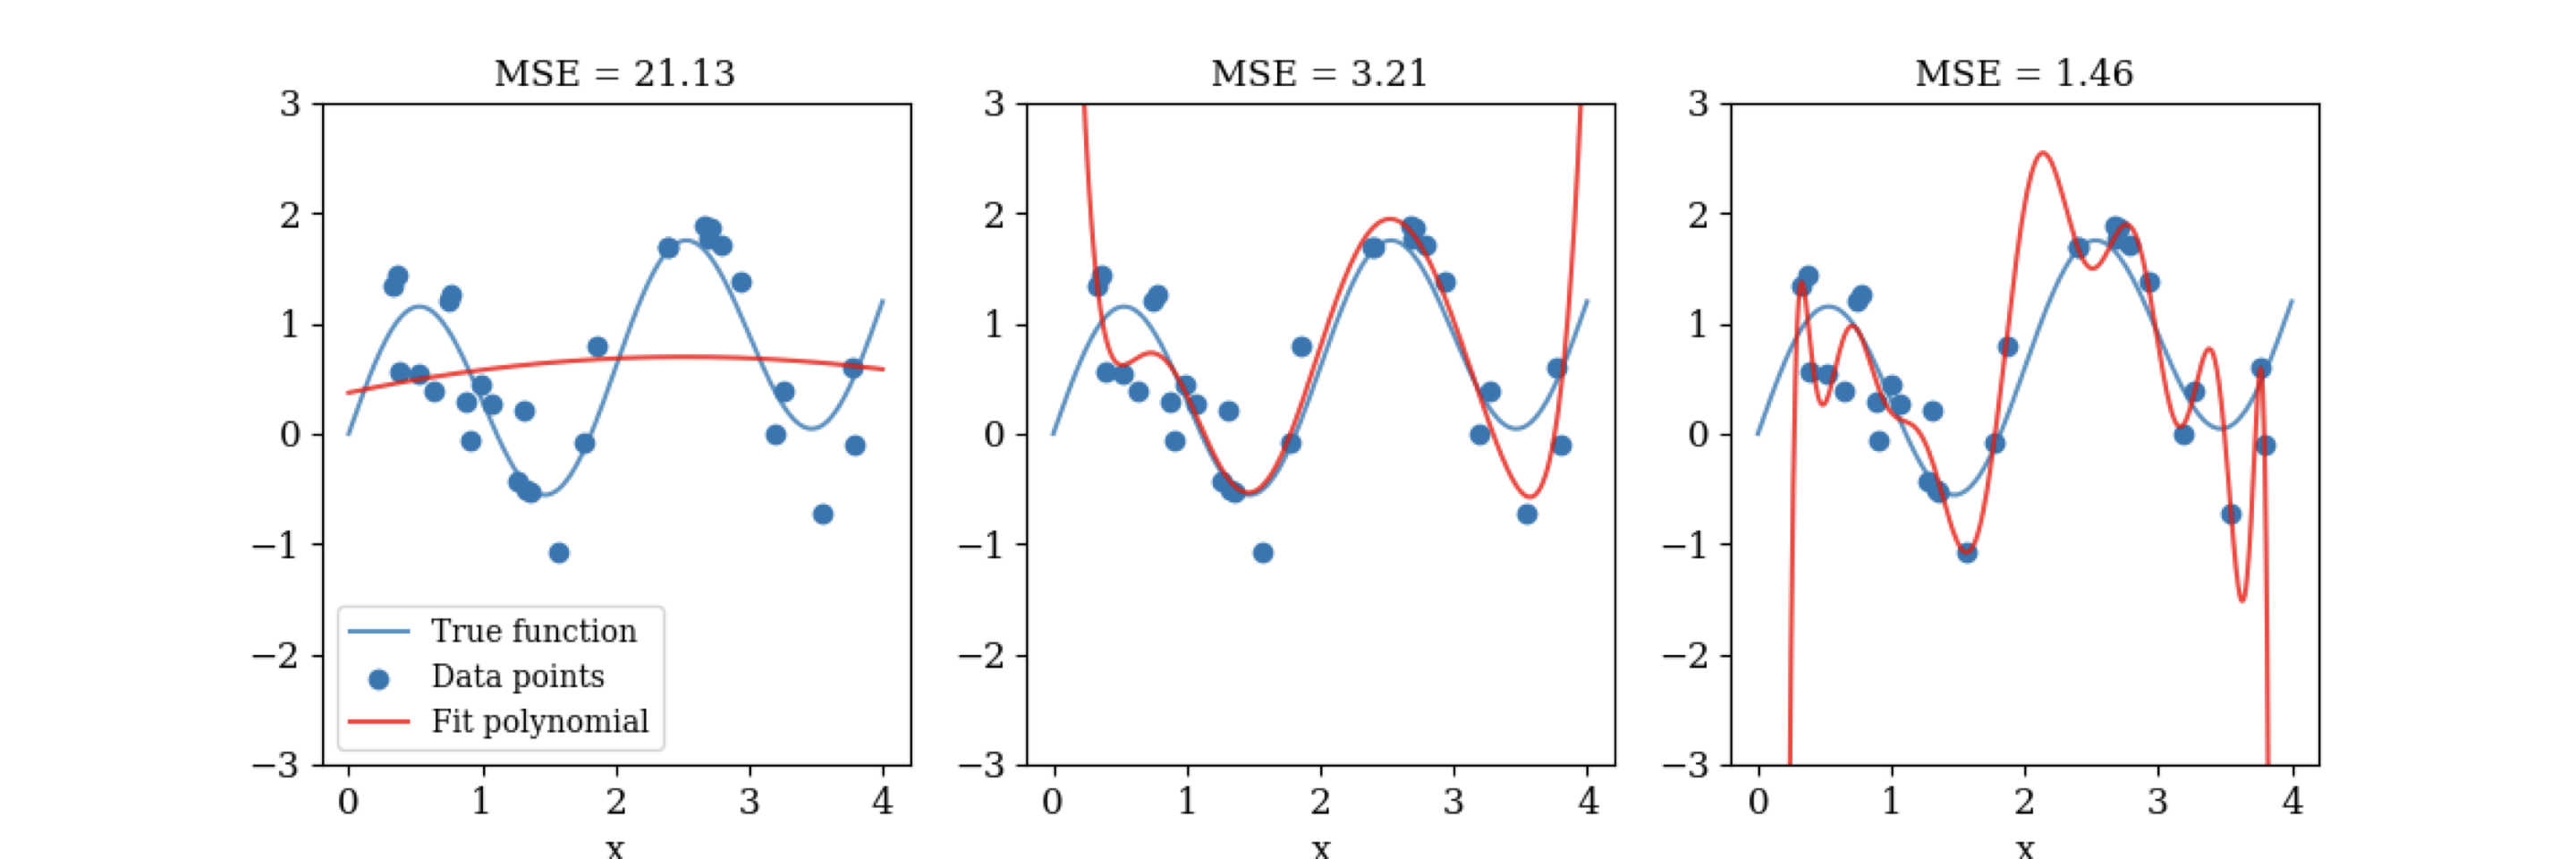

Increasing complexity makes the training sample fit better and better - but at some point it becomes too complex and does not generalise well. We call this **overfitting**, but when it is not complex enough it is also not good - that is the regime of **underfitting**.

The other story is that quality of fit measures are not miraculous and might or not work!


# Creating more complex models

Let us now move to a more complex example - one where we have multiple variables. This is a lot more typical! 

In [89]:
from astroML.datasets import fetch_sdss_sspp
from astropy.table import Table
import seaborn as sns
import pandas as pd

In [81]:
# This sets the default appearance of seaborn and its colour palette
sns.set(style="white")
sns.set_palette('colorblind')

In [76]:
# If you have good internet connection you can do this:
d = fetch_sdss_sspp()
t = Table(d)

In [68]:
# But if you have copied the Github site you can also load from file

In [82]:
t = Table().read("star_properties.fits")

In [84]:
t

ra,dec,Ar,upsf,uErr,gpsf,gErr,rpsf,rErr,ipsf,iErr,zpsf,zErr,pmL,pmB,pmErr,mjd,plate,fiber,SNR,FeH,FeHErr,Teff,TeffErr,logg,loggErr,alphFe,alphFeErr,radVel,radVelErr
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
49.627502,-1.0417559,0.2,17.619,0.018,16.177,0.019,15.563,0.02,15.362,0.023,15.249,0.021,4.87,-9.67,2.73,52932.0,1515.0,208.0,56.952,-0.49078,0.030473,5480.2,32.202,2.7466,0.86567,0.16446,0.05,-20.27,1.2338
40.27209,-0.6425011,0.085,19.241,0.034,17.526,0.02,16.84,0.017,16.613,0.019,16.492,0.018,-0.39,3.15,3.03,52591.0,1070.0,114.0,28.509,-0.45424,0.074101,5166.1,23.374,4.4887,0.12392,0.28739,0.0086588,-8.2099,1.5169
54.68342,0.2169363,0.248,20.869,0.094,19.574,0.023,19.068,0.022,18.836,0.019,18.738,0.054,6.8,10.59,3.85,54792.0,3156.0,413.0,22.855,-0.73413,0.0645,5573.2,74.674,4.1013,0.10648,0.38164,0.018238,-8.8528,2.8615
54.776966,0.2233347,0.281,19.734,0.042,18.335,0.022,17.663,0.022,17.446,0.021,17.247,0.033,2.47,2.55,3.26,54792.0,3156.0,409.0,52.957,-0.47688,0.041891,5391.3,23.108,4.3046,0.12903,0.22487,0.011503,-28.795,1.2334
55.106388,0.219215,0.24,20.606,0.081,19.061,0.022,18.515,0.022,18.301,0.02,18.131,0.033,-1.54,3.1,3.46,52619.0,1062.0,393.0,13.196,-0.44552,0.054758,5665.5,80.054,4.0536,0.20939,0.020483,0.016306,58.491,3.7639
55.743725,0.2163378,0.239,20.138,0.068,18.767,0.02,18.195,0.018,17.894,0.018,17.783,0.027,5.83,3.02,3.53,54792.0,3156.0,534.0,42.435,-1.2327,0.074413,5362.5,56.773,2.0169,0.14367,0.028524,0.025851,-126.55,2.1647
57.512115,0.0848679,0.647,18.81,0.029,17.644,0.018,17.107,0.017,16.852,0.018,16.73,0.019,14.28,-9.1,3.03,52930.0,1243.0,473.0,38.765,-1.3285,0.046063,6222.1,33.193,3.9756,0.10696,0.14833,0.01833,38.52,2.7689
57.512115,0.0848679,0.647,18.81,0.029,17.644,0.018,17.107,0.017,16.852,0.018,16.73,0.019,14.28,-9.1,3.03,52901.0,1242.0,486.0,26.565,-1.3044,0.050461,6228.4,26.344,3.9536,0.17932,0.25048,0.0083774,30.205,4.2831
57.512115,0.084868,0.647,18.81,0.029,17.644,0.018,17.107,0.017,16.852,0.018,16.73,0.019,14.28,-9.1,3.03,52998.0,1633.0,491.0,42.955,-1.275,0.063813,6268.1,35.377,4.0603,0.12287,0.17535,0.010194,31.552,2.8803


It can be useful to know what is in the data array! One good way is to check the [documentation of fetch_sdss_spp](http://www.astroml.org/modules/generated/astroML.datasets.fetch_sdss_sspp.html), another is to print `data.dtype.names` which will show you the name of the columns in the data.

## A brief explanation of the data

The main information here are the temperatures of the stars (Teff) and the brightness of the stars in different filters (different wavelengths), these are `upsf`, `gpsf` etc. The `u`, `g`, `r`, `i`, `z` correspond to increasing wavelenghts - `u` is for ultraviolet and has a wavelength in the order of $\sim 400$nm, `g` closer to $\sim 500$nm and so-on. These brightnesses (fluxes) are actually logarithmic quantities and as such are known as magnitudes, so that $u \propto \log_{10} \mathrm{flux}_u$. We do not need these details here - we can simply create what astronomers call "colours". These are differences of the magnitudes, so in practice what they are are the logarithm of the ratio of flux in one wavelength region to that in another region. 

So below we calculate the $u-g$ colour, the $g-r$, $r-i$ and $i-z$ colours (this order is standard and in this notation a smaller colour value is called 'bluer' and a larger value 'redder').

In [100]:
# Extract some data. 
ug = t['upsf']-t['gpsf']
gr = t['gpsf']-t['rpsf']
ri = t['rpsf']-t['ipsf']
iz = t['ipsf']-t['zpsf']
T = t['Teff']

In [87]:
# Understand what the line below does! Try without the transpose and see the shape.
X = np.vstack((ug, gr, ri, iz, T)).T
M = np.vstack((ug, gr, ri, iz)).T

## Visualisation of the data

A good way to visualise data like this is to use a pair plot grid - this is provided by Seaborn in the `PairGrid` function. This allows lower and upper and diagonals to show different things. The lower half and diagonals show Kernel Density plots - we will come back to these later in the course - for now think of them as smooth versions of 2D and 1D histograms respectively. (this does take a bit to run btw! but to make it quicker I only use the first 1000 points).

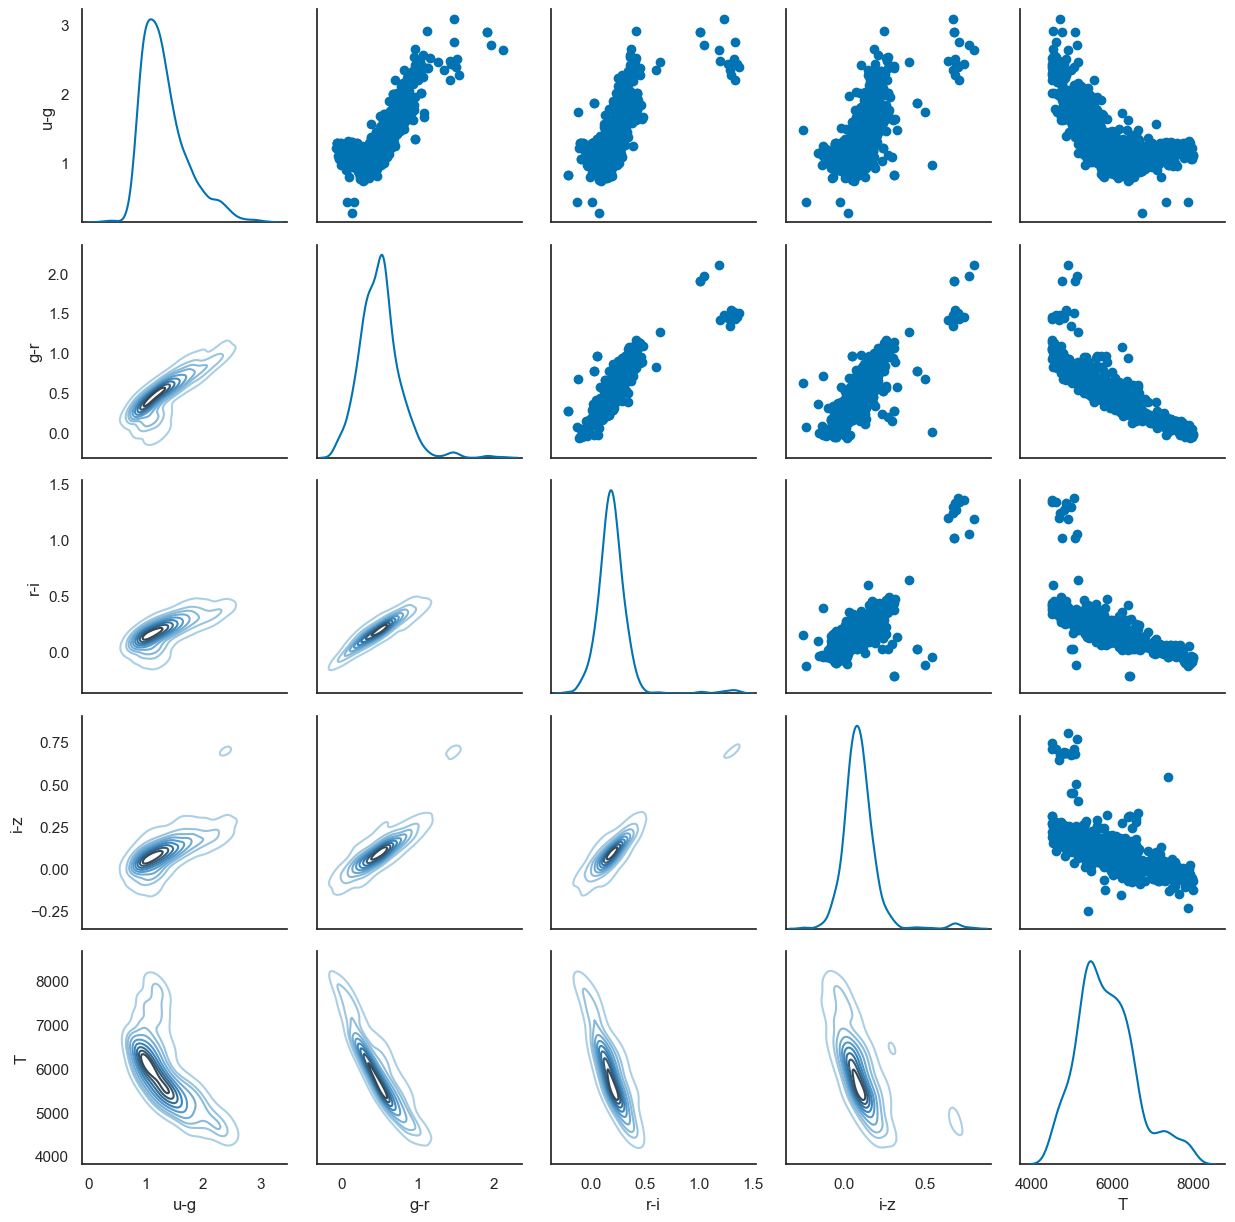

In [90]:
# Here I make a Pandas's DataFrame because this works nicely with Seaborn 
df = pd.DataFrame(X[0:1000, :], columns=['u-g', 'g-r', 'r-i', 'i-z', 'T'])
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)

There is plenty of co-linearity in this data. Let me now assume that we can write

$$T = \theta_0 + \theta_1 (u-g) + \theta_2 (g-r) + \theta_3 (r-i) + \theta_5 (i-z) $$

and we want to constrain $\theta$.

Your task now is to do this for different types of regression. Your task now is to do this for different types of regression. I will show first how to do it for linear regression and then we'll create a simple set of functions to repeat this

In [93]:
from astroML.linear_model import LinearRegression

/Users/jarle/Source/astroML/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [94]:
# This is the standard setup for fitting. I use temperatures in units of 10^4 K to avoid enormous numbers in the fit
model = LinearRegression(fit_intercept=True)
res = model.fit(M, T/1e4)
Tpred = model.predict(M)
residuals = Tpred*1e4-T
relative_residuals = residuals/T
c = list(res.coef_)
print(" The best-fit model is:\n   T = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4]))


 The best-fit model is:
   T = 0.690+ 0.025 (u-g) + -0.261 (g-r) + -0.083 (r-i) + 0.035 (i-z)


## A common structure

This structure you see here:

- Create a model
- Fit the data
- Calculate the predicted values

Is a very standard way to do machine learning in Python (at least with `sklearn`). We will do two regularised regression methods next, but first a short aside about visualisation

Now for a first go at the residual plot. This just creates two scatter plots with the residuals on the left and the relative residuals on the right. This is not a very good plot.

Text(0, 0.5, '$(T_{pred}-T)/T$')

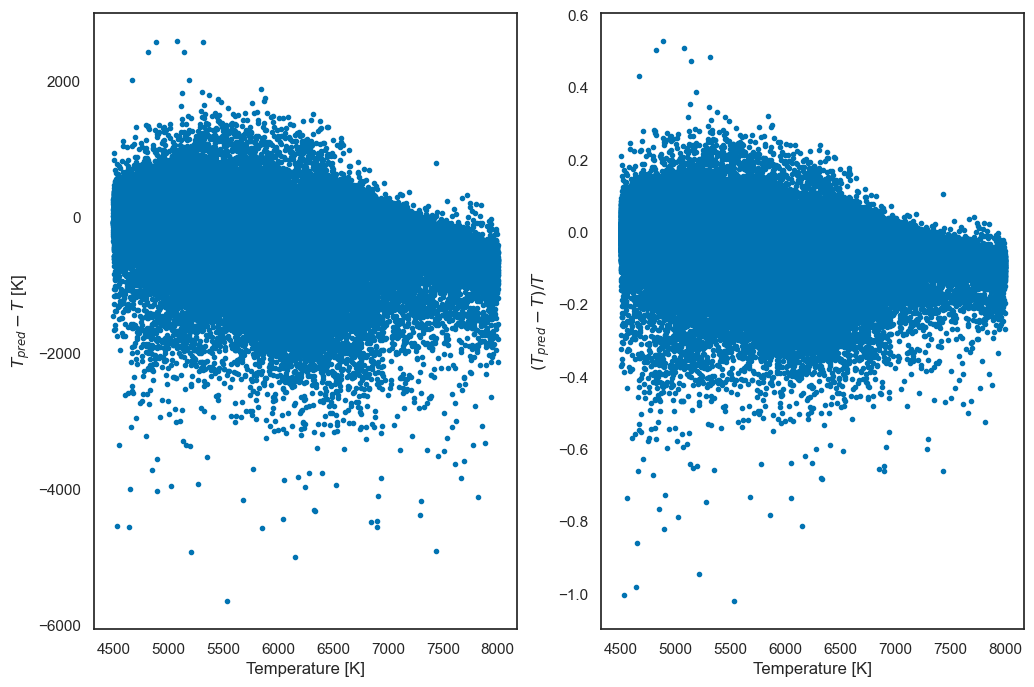

In [95]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
axes[0].scatter(T, residuals, marker='.')
axes[0].set_xlabel('Temperature [K]')
axes[0].set_ylabel(r'$T_{pred}-T$ [K]')

axes[1].scatter(T, relative_residuals, marker='.')
axes[1].set_xlabel('Temperature [K]')
axes[1].set_ylabel(r'$(T_{pred}-T)/T$')


Now what is bad about these figures? There are a few problems:

 1. They obscure the data. There are so many datapoints you can't see any structure.
 2. They actually provide very little information as such. 
 3. The labels are arguably too small.
 4. My impression is that the aspect ratio is wrong for the data.
 5. The residuals should be symmetric around zero if all is well, but as the y-axis is asymmetric it is hard to judge whether the residuals are symmetric around zero
 
These two figures also provide very similar information. Although it is not exactly the same, I'll just improve the relative residual plot on the left. 

So how can we tackle these issues? 

**Obscured data**: This is relatively easy. We can use transparency of the points (that is the solution I'll use below), and we can obscure the individual data points more by creating a 2D histogram or a 2D kernel density plot, but since that is the next lecture I won't do that. 

**Little information**: With so much data it is useful to overplot, say the median trend line on the data and possibly a regression fit to the data to see whether there is a slope to data, or to colour the points by some colour.  Of course to carry out this properly we should look at the trend of residuals with the various colours & there are a bunch of diagnostic plots one can use for regression models. 

The median of a value Y in a small window in x is called the running or rolling median or sometimes the median trend line. Calculation of a running median for large data can be a bit slow but you can speed things up if your data is sorted or various other situations. Below I calculate it in a very simple way but there are also other things one can do.

**Labels**: Straightforward fix.

**Aspect ratio**: This is easily fixed, and in particular for us because we will now only plot one panel.

**Y-range**: We just set the y-limits to be symmetric around zero

In [96]:
def running_median(x, y, N=10, binsize=None):
    """Calculate the median in N windows, or windows of size binsize.
    
    This ignores all edge effects - caveat emptor
    """

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # This finds the bins that each x should go in.
    # This is convenient for expanding the routine to accept other functions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    # I also want the x-positions in the bins. I use mean for that
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

In [97]:
x_m_regular, med_regular, bins = running_median(T, relative_residuals, binsize=100)

/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jarle/miniforge3/envs/mld2024/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


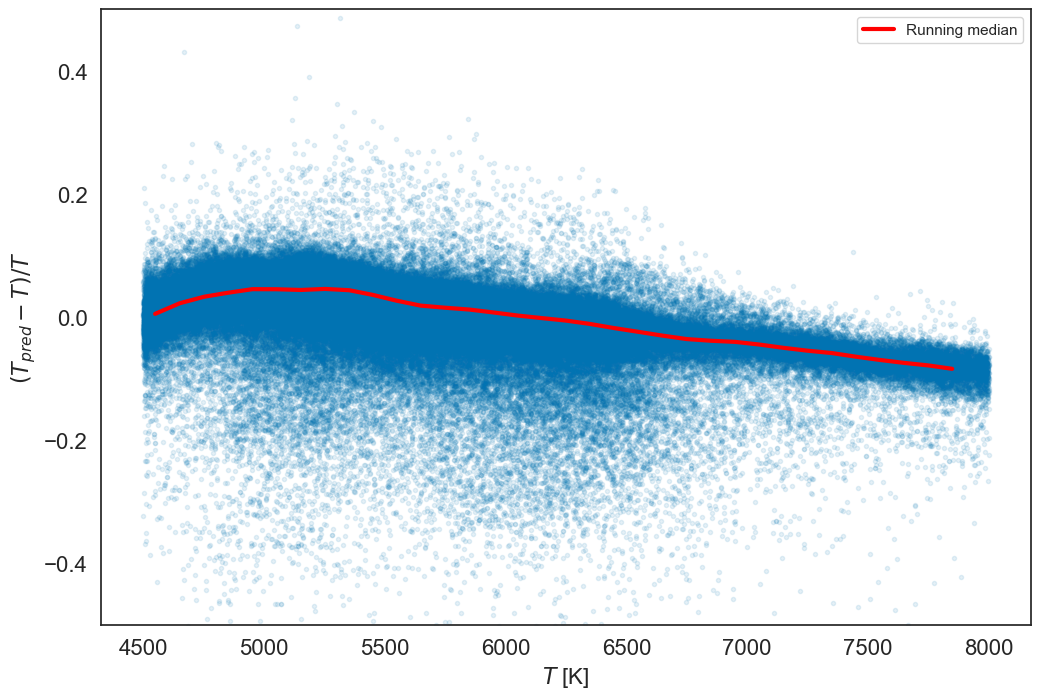

In [101]:
# I'll still use the subplots notation so that it is easy to modify if I want to add more panels.

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.scatter(T, relative_residuals, marker='.', alpha=0.1)
ax.plot(x_m_regular, med_regular, lw=3, color='red', label='Running median')

ax.set_xlabel(r'$T$ [K]', fontsize=16)
ax.set_ylabel(r'$(T_{pred}-T)/T$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.5,0.5)
plt.legend()


## Other types of regression



In [110]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

To be efficient it is useful to wrap up these tasks into functions - and also to switch to what is known as pipelines.

In [120]:
def create_pipeline(method):
    """Create a pipeline for fitting a regressor (and many more models actually)
    
    Arguments:
        method: a method to use for the fitting of the data.

    Return: 
        P: a pipeline object. P[0] will contain the standard scaler, P[1] the fit object.
    
    """
    P = make_pipeline(
        StandardScaler(with_mean=False), 
        method)

    return P
    
def run_fit(P, M, y):
    """Fit data with pipeline P

    Arguments:
        P: The pipeline
        M: The design matrix
        y: The response variables

    Returns:
        res: a fit object - the content depends on the model used in the pipeline

    """
    res = P[1].fit(P[0].fit_transform(M), T/1e4)
    # The StandardScaler scales the data - this corrects back.
    res.coef_ = res.coef_/P[0].scale_

    return res
    
def calculate_residuals(P, M, y_true):
    """Calculate the residuals of a fit

    Arguments:
       P: the pipeline object
       M: the design matrix
       y_true: the true values

    Returns:
       y_pred: the predicted values
       residuals: the residuals calculated as y_predicted-y_true
       relative_residuals: the residuals divided by y_true

    """
    y_pred = P[1].predict(M)
    residuals = y_pred-y_true
    # This works badly if y_true is zero...
    relative_residuals = residuals/y_true

    return y_pred, residuals, relative_residuals

def report_linear_regression_coefficients(res):
    """This reports the linear regression coefficient

    This particular code is very specialised and needs modifications for any
    other situation
    """

    # Note that the intercept for ridge regression is somewhat hidden..
    c = [res.intercept_]
    [c.append(coeff) for coeff in res.coef_]

    print(" The best-fit model is:\n   T = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4]))



## Testing out Ridge and LASSO regression.

In linear regression we fit models of the type 
$$
\hat{y}_i = \theta_0 + \sum_{j=1}^p \theta_j x_{ij},
$$
where $\theta_i$ are the _parameters_ of the model, $y_i$ are the model outputs or response variables and $x_{ij}$ are the input or independent variables. In standard linear regression we minimize the sum of squares
$$
\mathrm{RSS} = \sum_i \left(y_i - \hat{y}_i\right)^2.
$$

But when there are many outliers, the parameters of the model can go very far from the correct values - they are sensitive to outliers. To reduce this sensitivity, we regularise the fit. We do that my adding a Lagrange multiplier to the quantity we try to minimise, so we minimise
$$
\mathrm{RSS} = \sum_i \left(y_i - \hat{y}_i\right)^2 + \lambda f(\theta),
$$
where $f(\theta) = \sum_j \theta_j^2$ in **Ridge regression** and $f(\theta) = \sum_j |\theta_j|$ in **LASSO regression**.

They are particularly useful for avoiding large deviations in the fits when small numbers are used, and you will frequently find them used as parts of a larger model. With the framework above - they are easy to fit, but note that `sklearn` uses `alpha` for setting `lambda`...

In [125]:
# Ridge regression:
method_ridge = Ridge(alpha=0.1, fit_intercept=True)

P = create_pipeline(method_ridge)
# This does the actual fit.
y = T/1e4
res = run_fit(P, M, y)
Tpred, residuals, relative_residuals = calculate_residuals(P, M, y)
# If you want residuals in Kelvin, then you need to multiply by 10^4

report_linear_regression_coefficients(res)

 The best-fit model is:
   T = 0.690+ 0.025 (u-g) + -0.261 (g-r) + -0.083 (r-i) + 0.035 (i-z)


In [133]:

# LASSO regression:
method_lasso = Lasso(alpha=1e-4, fit_intercept=True)

P = create_pipeline(method_lasso)
# This does the actual fit.
y = T/1e4
res = run_fit(P, M, y)
Tpred, residuals, relative_residuals = calculate_residuals(P, M, y)
# If you want residuals in Kelvin, then you need to multiply by 10^4

report_linear_regression_coefficients(res)

 The best-fit model is:
   T = 0.690+ 0.024 (u-g) + -0.257 (g-r) + -0.083 (r-i) + 0.029 (i-z)


**Task**: try different values for the `alpha` parameters of LASSO and see what happens to the coefficients.

In [140]:
# Different regularisation parameters:
lambda_values = np.logspace(-4, -1, 50)
N_lambda = len(lambda_values)
coeffs = np.zeros((5, N_lambda)) # We have five coefficients.

for i, l in enumerate(lambda_values):
    method_lasso = Lasso(alpha=l, fit_intercept=True)
    P = create_pipeline(method_lasso)
    y = T/1e4
    res = run_fit(P, M, y)

    coeffs[0, i] = res.intercept_
    coeffs[1:5, i] = res.coef_


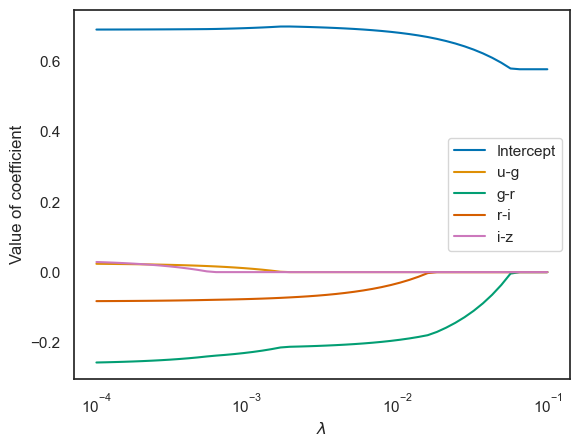

In [147]:
labels = ['Intercept', 'u-g', 'g-r', 'r-i', 'i-z']
fig, ax = plt.subplots(ncols=1, nrows=1)
for i_coeff in range(5):
    ax.plot(lambda_values, coeffs[i_coeff, :], label=labels[i_coeff])
        
ax.set_xscale('log')
ax.set_ylabel("Value of coefficient")
ax.set_xlabel(r"$\lambda$")
plt.legend()

## Ensemble regressions

We will now turn to ensemble methods - but I'll put that in a different notebook, however we can try it out here for the fitting:

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error')

##
# You can try running this - but it will take a long time probably!!

#P = create_pipeline(method_RF)
# This does the actual fit.
#y = T/1e4
#res = run_fit(P, M, y)
#Tpred, residuals, relative_residuals = calculate_residuals(P, M, y)